In [1]:
import numpy as np
import os
import util as u
from MRI_layers_MK1 import *
import matplotlib.pyplot as plt
import pickle

In [2]:
base = "/Users/nathanielnethercott/Desktop/School/2021/Pickled_Sample/"
fpaths = [os.path.join(base,p) for p in os.listdir(base)]

In [3]:
test = pickle.load(open(fpaths[0], 'rb'))

In [4]:
def _find_layers(mask_data):
    l = []
    for i in range(mask_data.shape[-1]):
        if np.mean(mask_data[:,:,i])>0.0:
            l.append(i)
    return l

t1 = test[1]
t2 = test[2]

#only interested in scans with lesions
_masks = [t2[:,:,i] for i in _find_layers(t2)]
_scans = [t1[:,:,i] for i in _find_layers(t2)]

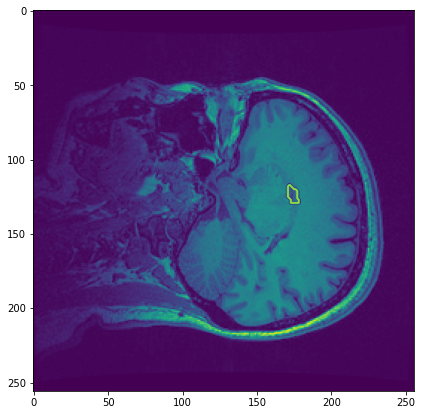

In [5]:
plt.figure(figsize=(7,7))
plt.imshow(_scans[12])
plt.contour(_masks[12])

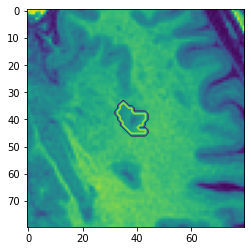

In [12]:
ref = 1
img = _scans[ref]/255
mask = _masks[ref]/255

subimg = img[85:165, 130:210]
submask = mask[85:165, 130:210]
plt.imshow(subimg)
plt.contour(submask)

#for 0: 85:165, 130:210

In [15]:
#try some pillow stuff 
from PIL import Image, ImageEnhance, ImageOps
from matplotlib import cm

#convert to pil image adding a color map?
#np.uint8(cm.gray(subimg)*255)
pil_im = Image.fromarray(subimg)
pil_im = ImageOps.grayscale(pil_im)

#enhancer
enhancer = ImageEnhance.Contrast(pil_im)

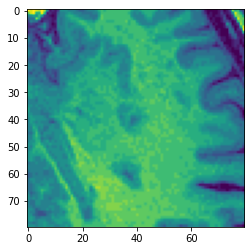

In [16]:
plt.imshow(pil_im)

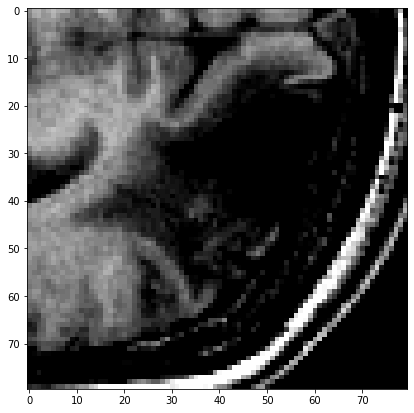

In [12]:
im = enhancer.enhance(4)

plt.figure(figsize=(7,7))
plt.imshow(im, cmap='gray')
#plt.contour(submask, [0], colors=['red'], linewidths=0.9)

In [13]:
# need this...
def iteration(surface, image, dt=0.0001, alpha = 1, beta=1):
    d = lambda x,y: (x**2 + y**2)**0.5

    #absolutely do not forget to add this grid spacing in the function argument 
    sy, sx = np.gradient(surface, np.linspace(-1,1, surface.shape[0]), np.linspace(-1,1, surface.shape[1]))

    #write logic for the time evolution of the curves 
    #surface curvature 
    K = u.mean_curvature(surface)

    #now the evolution function:
    F1 = K
    F2 = (image-1.0)**2 - (image - 0)**2

    surface = surface - (beta*F2+alpha*F1)*d(sx,sy)*dt

    return surface

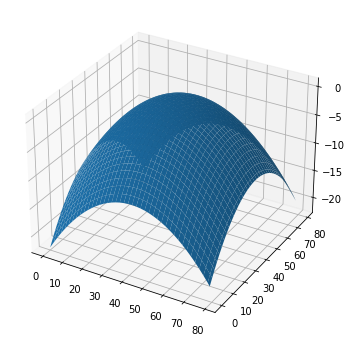

In [16]:
u.showsurf(p)

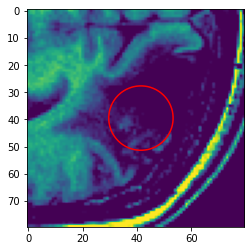

In [14]:
#try a segmentation functional with this now (we use code from scans2...)
c_subimg = np.array(im)
c_subimg = c_subimg/255

#first converge 
p = u.parabloid(subimg.shape, xrad=0.3, yrad=0.3, left = 0.05, top=-0.0)
plt.contour(p, [0], colors=['red'])
plt.imshow(c_subimg)

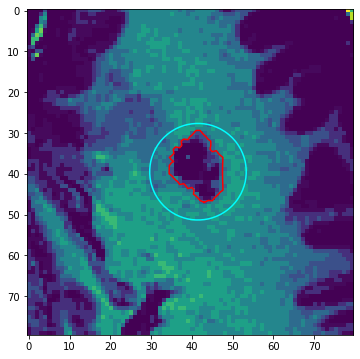

In [30]:
g = p
for i in range(3000):
    g = iteration(g, submask, dt = 0.001, beta=0.11, alpha=0.001)

plt.figure(figsize=(6,6))
plt.contour(g, [0], colors=['red'])
plt.contour(p, [0], colors=['cyan'])
plt.imshow(c_subimg)

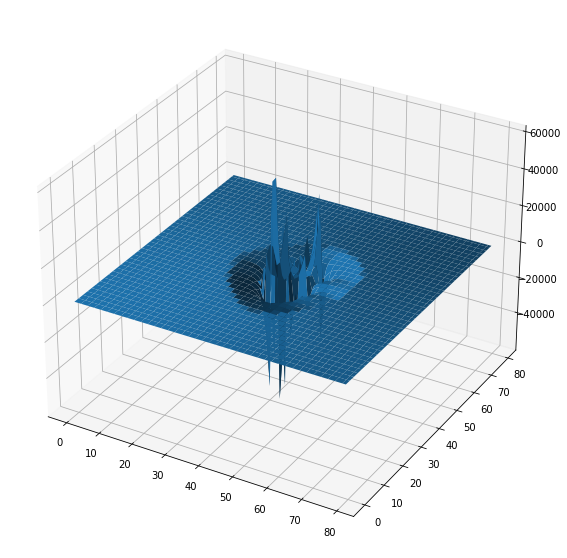

In [31]:
u.showsurf(g)

In [34]:
#now lets check averages inside and out for contrasted image 
indeces = list(zip(*np.where(p>=0)))

#recall: g1 is the iterate 
_indeces = list(zip(*np.where(g>=0)))

print(f'ratio: {len(_indeces)/len(indeces)}')

ratio: 0.34684684684684686


In [35]:
i_out = 0
i_in = 0

#sum of intensities in original circle 
for i in indeces:
    i_out+=c_subimg[i[0],i[1]]

#subtract whats in the actual legion from circle and find legion net intensity 
for i in _indeces:
    i_out-=c_subimg[i[0],i[1]]
    i_in +=c_subimg[i[0],i[1]]
    
i_out = i_out/(len(indeces) - len(_indeces))
i_in = i_in/len(_indeces)
print(f'inside: {i_in}, outside: {i_out}')

inside: 0.014132925897631779, outside: 0.06861392832995249


In [36]:
#idea for time speed up: once professional identifies first lesion then crop future images 

#now lets see what happens when we use the new segmentation with the values determined above
def _iteration(surface, image, dt=0.0001, alpha = 1, beta=1):
    d = lambda x,y: (x**2 + y**2)**0.5

    #absolutely do not forget to add this grid spacing in the function argument 
    sy, sx = np.gradient(surface, np.linspace(-1,1, surface.shape[0]), np.linspace(-1,1, surface.shape[1]))

    #write logic for the time evolution of the curves 
    #surface curvature 
    K = u.mean_curvature(surface)

    #now the evolution function:
    F1 = K
    #segmentation
    F2 = (image-0.01413292)**2 - (image - 0.06861392)**2

    surface = surface - (beta*F2+alpha*F1)*d(sx,sy)*dt

    return surface

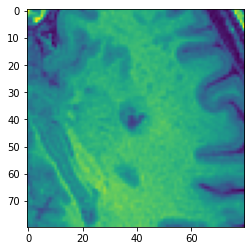

In [18]:
#let's take a look at the next image in the scans... not next but a few images up (so its sufficiently different)
nextimg = _scans[ref+1]/255
nextmask = _masks[ref+1]/255

subnextimg = nextimg[85:165, 130:210]
subnextmask = nextmask[85:165, 130:210]

plt.imshow(subnextimg)
#plt.contour(subnextmask, [0])
#plt.contour(submask, [0])

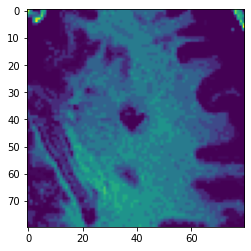

In [19]:
#apply preprocessing 
#Note: values used in seg functional dependent on constrast factor 
def preprocess(im_array, cfactor=8):
    """
    assume data isn't normalized 
    we convert to grayscale 
    we constrast 
    """
    pil_im = Image.fromarray(im_array)
    pil_im = ImageOps.grayscale(pil_im)
    
    #enhancer 
    enhancer = ImageEnhance.Contrast(pil_im)
    im = enhancer.enhance(cfactor)
    
    return np.array(im)/255
    

#contrast
c_next = preprocess(subnextimg, cfactor=4)
plt.imshow(c_next)

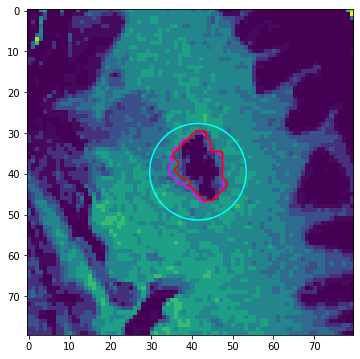

In [41]:
#now lets check some stuff quick to make sure values in and out are viable choices 

#generate a neighborhood 
p1 = u.parabloid(subimg.shape, xrad=0.3, yrad=0.3, left = 0.05, top=-0.0)
#first converge 
g1 = g

for i in range(1200):
    g1 = iteration(g1, subnextmask, dt = 0.001, beta=0.11, alpha=0.001)

plt.figure(figsize=(6,6))
plt.contour(g, [0], colors=['magenta'])
plt.contour(g1, [0], colors=['red'])
plt.imshow(c_next)
plt.contour(p, [0], colors=['cyan'])

In [42]:
#now find some interior/exterior vals 
#now lets check averages inside and out for contrasted image 
indeces = list(zip(*np.where(p1>=0)))

#recall: g1 is the iterate 
_indeces = list(zip(*np.where(g1>=0)))

i_out = 0
i_in = 0

#sum of intensities in original circle 
for i in indeces:
    i_out+=c_next[i[0],i[1]]

#subtract whats in the actual legion from circle and find legion net intensity 
for i in _indeces:
    i_out-=c_next[i[0],i[1]]
    i_in +=c_next[i[0],i[1]]
    
i_out = i_out/(len(indeces) - len(_indeces))
i_in = i_in/len(_indeces)
print(f'inside: {i_in}, outside: {i_out}')

inside: 0.0165266106442577, outside: 0.06914344685242499


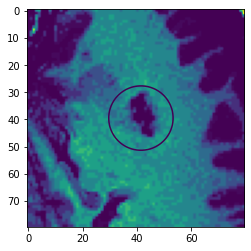

In [43]:
plt.contour(p1, [0])
#plt.contour(subnextmask, [0])
plt.imshow(c_next)

<ipython-input-59-89efb7f249e1>:11: UserWarning: No contour levels were found within the data range.
  plt.contour(subnextmask, [0], colors=['cyan'])


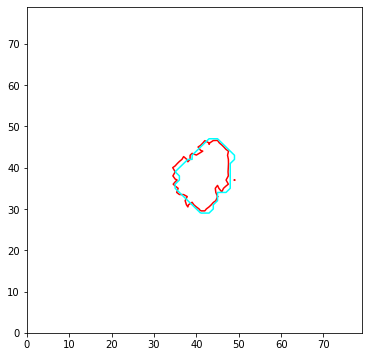

In [59]:
#okay now lets do the thing 
g11 = g

for i in range(4000):
    g11 = _iteration(g11, c_next, dt = 0.0001, beta=0.11, alpha=0.005)

plt.figure(figsize=(6,6))
plt.contour(g11, [0], colors=['red'])
#plt.contour(p, [0], colors=['cyan'])
#plt.imshow(c_next)
plt.contour(subnextmask, [0], colors=['cyan'])
#plt.contour(submask, [0], colors=['magenta'])

<ipython-input-60-54d60ef59838>:5: UserWarning: No contour levels were found within the data range.
  plt.contour(subnextmask, [0], colors=['cyan'])
<ipython-input-60-54d60ef59838>:6: UserWarning: No contour levels were found within the data range.
  plt.contour(submask, [0], colors=['magenta'])


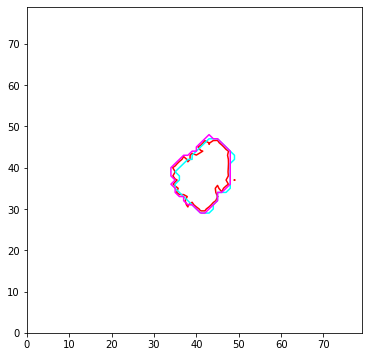

In [60]:
plt.figure(figsize=(6,6))
plt.contour(g11, [0], colors=['red'])
#plt.contour(p, [0], colors=['cyan'])
#plt.imshow(c_next)
plt.contour(subnextmask, [0], colors=['cyan'])
plt.contour(submask, [0], colors=['magenta'])

In [165]:
#try convergence with a circle as above 

def surf2simple(surface, threshold = 0.05):
    
    #two step process
    #step 1
    s = -1*np.ones(surface.shape)
    positive_indeces = list(zip(*np.where(surface>0)))
                            
    for index in positive_indeces:
        s[index] = 1
    
    #step 2
    ny, nx = np.gradient(s)
    n = ny**2+nx**2
    zero_indeces = list(zip(*np.where(n>0)))
    
    for index in zero_indeces:
        s[index] = 0
    
    return s 
  
                             
p_ = surf2simple(p)

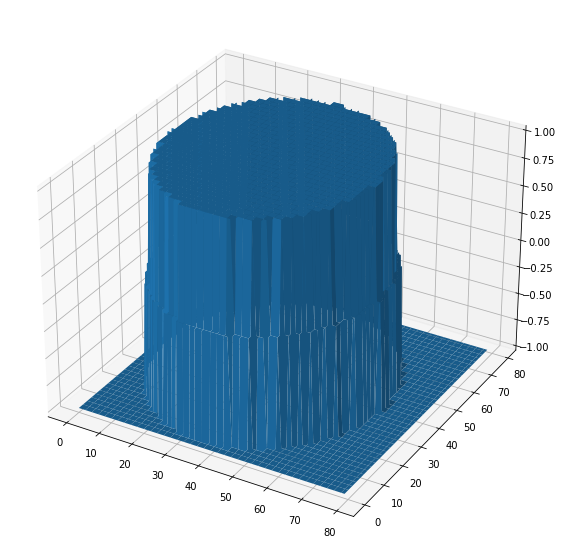

In [159]:
u.showsurf(p_)

<ipython-input-166-d899ba0e94ec>:9: UserWarning: No contour levels were found within the data range.
  plt.contour(submask, [0], colors=['magenta'])


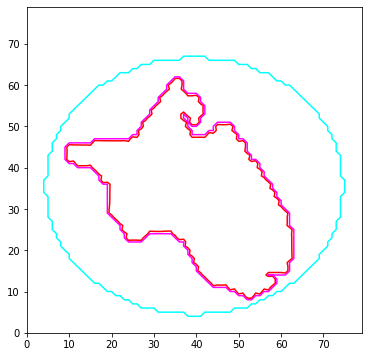

In [166]:
#okay lets try this quick 
g_ = p_

for i in range(6500):
    g_ = iteration(g_, submask, dt = 0.001, beta=0.11, alpha=0.001)

plt.figure(figsize=(6,6))
plt.contour(g_, [0], colors=['red'])
plt.contour(submask, [0], colors=['magenta'])
plt.contour(p_, [0], colors=['cyan'])
#plt.imshow(c_subimg)

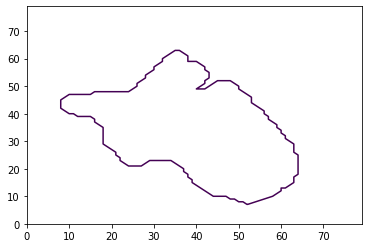

In [262]:
#this is the best i can come up with rn 
def stretch(simpsurf, simpcirc):
    '''
    we require simplified surfaces and then we average heights and such 
    '''
    s = (simpsurf+simpcirc)/2
    return s

stretched = stretch(simplified, p_)
plt.contour(stretched, [0])

In [275]:
#bad idea to to things with simple surfaces for one reason or another 

In [ ]:
#should we try to do the looping iterates?
#maybe later...
#try with good ones 

In [61]:
"""
pseudo-code 

scan data: 3d array of scan images 

step 1: medical professional outlines first lesion 
step 2: compute properties based on the known lesion (intensity i/o, contour lenght)

pipeline:
raw image --> preprocess --> s

idea: regression for arclength estimation 

run with and without contrasting
"""

'\npseudo-code \n\nscan data: 3d array of scan images \n\nstep 1: medical professional outlines first lesion \nstep 2: compute properties based on the known lesion (intensity i/o, contour lenght)\n\npipeline:\n'

In [68]:
def converged2mask(surf):
    mask = np.zeros((surf.shape[0], surf.shape[1]))
    positive_indeces = list(zip(*np.where(surf>=0)))
    for index in positive_indeces:
        mask[index] = 1.0
    return mask 

<ipython-input-78-c5d4faa6810c>:3: UserWarning: No contour levels were found within the data range.
  plt.contour(subnextmask, [0], colors='red')


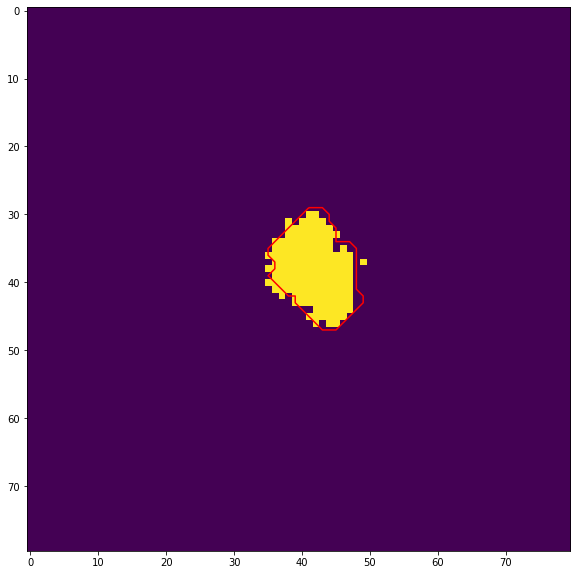

In [78]:
plt.figure(figsize=(10,10))
plt.imshow(converged2mask(g11))
plt.contour(subnextmask, [0], colors='red')